In [1]:
import numpy as np
from scipy import stats
from scipy.spatial.distance import cdist

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 
          'xkcd:sea blue', 
          'xkcd:pale red', 
          'xkcd:sage green', 
          'xkcd:terra cotta', 
          'xkcd:dull purple', 
          'xkcd:teal', 
          'xkcd:goldenrod', 
          'xkcd:cadet blue', 
          'xkcd:scarlet']

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Linear regression

In linear regression, 
- a set of $n$ observations of two variables $\mathbf{x}\in\mathbb{R}^d,t\in\mathbb{R}$: $(\mathbf{x}_1,t_1),\ldots,(\mathbf{x}_n,t_n))$ is available. We wish to exploit these observations to predict, for any new element $\mathbf{x}$, the corresponding unknown target value $t$
- the training set is a pair of vectors $\mathbf{X}=(\mathbf{x}_1,\ldots,\mathbf{x}_n)^T$ and $\mathbf{t}=(t_1,\ldots,t_n)^T$, related through an unknown rule (function)
  
We wish to predict the target $t$ associated to an input element $\mathbf{x}=(x_1,\ldots,x_d)$ through a suitable linear combination of the element features
$$
h(\mathbf{x},\mathbf{w})=w_0+\sum_{i=1}^dw_ix_i
$$
More compactly, $h(\mathbf{x},\mathbf{w})=\mathbf{w}\cdot\overline{\mathbf{x}}=\overline{\mathbf{x}}^T\mathbf{w}$, where $\overline{\mathbf{x}}=(1,x_1,\ldots,x_d)$.

This is a linear function both of parameters $\mathbf{w}$ and of features $\mathbf{x}$.


### Linear basis function models

Indeed, linear regression models share the property of being linear in their parameters but not necessarily in their input variables. Using non-linear basis functions of input variables, linear models are able to model arbitrary non-linearities from input variables to targets. Polynomial regression is such an example and will be demonstrated later. A linear regression model $y(\mathbf{x}, \mathbf{w})$ can therefore be defined more generally as

$$
h(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{m-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x})} = \boldsymbol\phi(\mathbf{x})^T\mathbf{w} \tag{1}
$$

where $\phi_j$ are basis functions and $m$ is the total number of parameters $w_j$ including the bias term $w_0$. Here, we use the convention $\phi_0(\mathbf{x}) = 1$. 

Most common families of base functions are:
- Polynomial base functions $\phi_{j}(x)=x^{j}$
- Gaussian base functions $\phi_{j}(x)=\exp\left(-\frac{(x-\mu_{j})^{2}}{2s^{2}}\right)$ (local)
- Sigmoid base functions $\phi_{j}(x)=\sigma\left(\frac{x-\mu_{j}}{s}\right)=\frac{1}{1+\exp\left(-\frac{x-\mu_{j}}{s}\right)}$
- Hyperbolic tangent functions $\phi_{j}(x)=\tanh(x)=2\sigma(x)-1=\frac{1-\exp\left(-\frac{x-\mu_{j}}{s}\right)}{1+\exp\left(-\frac{x-\mu_{j}}{s}\right)}$

Observe that gaussians, sigmoids and hyperbolic tangents are all `local` functions, in the sense that they are (essentially) constant almost everywhere
 
The simplest form of linear regression models are also linear functions of their input variables i.e. the set of basis functions in this case is the identity $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$. 


In [4]:
from functools import partial

def identity_basis_function(x):
    return x

def gaussian_basis_function(x, mu=1, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

def polynomial_basis_function(x, power=2):
    return x ** power

def sigmoid_basis_function(x, mu=1, sigma=0.1):
    return 1/(1+np.exp(-((x-mu)/sigma)))

def tanh_basis_function(x, mu=1, sigma=0.1):
    return 2/(1+np.exp(-((x-mu)/sigma)))-1

def expand(x, bf=None, bf_args_list=None):
    if np.isscalar(x):
        x = np.full((1,1),x)
    if bf:
        if bf_args_list:
            l = np.array([partial(bf, **bf_args)(x) for bf_args in bf_args_list]).squeeze().T
            if l.ndim==1:
                l = l.reshape(-1,1)
        else:
            l = np.array(bf(x))
    else:
        l = np.c_[np.ones(x.shape[0]), x].squeeze()
    if x.shape[0]==1 or l.ndim==1:
        return l.reshape(1,-1)
    else:
        return l

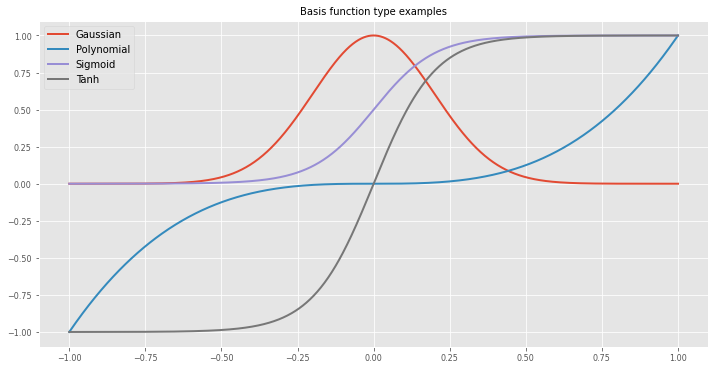

In [5]:
fig =plt.figure(figsize=(12,6))
x = np.linspace(-1,1,1000)
plt.plot(x, partial(gaussian_basis_function, **{'mu':0, 'sigma':0.2})(x), label='Gaussian')
plt.plot(x, partial(polynomial_basis_function, **{'power':3})(x), label='Polynomial')
plt.plot(x, partial(sigmoid_basis_function, **{'mu':0, 'sigma':.1})(x), label='Sigmoid')
plt.plot(x, partial(tanh_basis_function, **{'mu':0, 'sigma':.1})(x), label='Tanh')
plt.legend()
plt.title('Basis function type examples')
plt.show()

### Example datasets

The datasets used in the following examples are based on $n$ scalar observations $x_i, i = 1,\ldots,n$ which are combined into a $n \times 1$ matrix $\mathbf{X}$. Target values $\mathbf{t}$ are generated from $\mathbf{X}$ with functions `f` and `g` which also generate random noise whose variance can be specified with the `noise_variance` parameter. We will use `f` for generating noisy samples from a straight line and `g` for generating noisy samples from a sinusoidal function.

In [6]:
f_w0 = -0.3
f_w1 =  0.5

def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0+f_w1*X+noise(X.shape, noise_variance)

def g(X, noise_variance):
    '''Sinusoidal function plus noise'''
    return 0.5+np.sin(2*np.pi*X)+noise(X.shape, noise_variance)

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [7]:
x = np.linspace(-1, 1, 1000).reshape(-1, 1)
X = np.random.rand(50, 1)*2-1

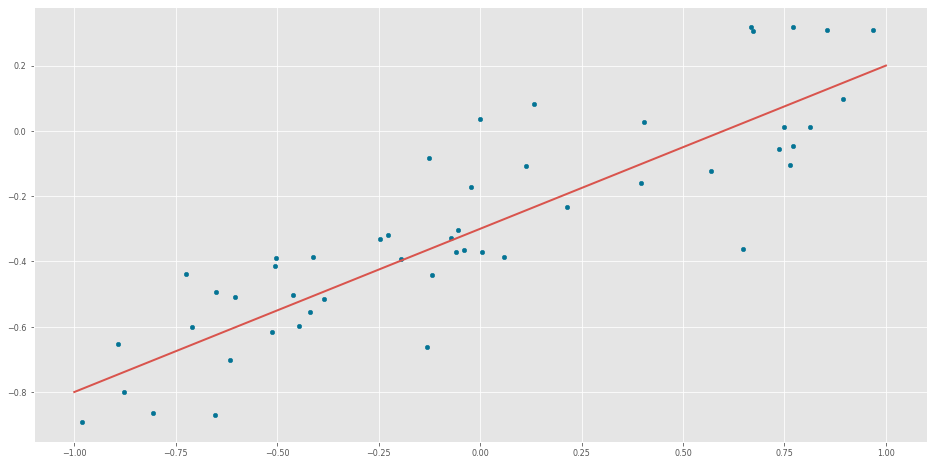

In [8]:
beta = 40.0
t1 = f(X, noise_variance=1/beta)
y1 = f(x, noise_variance=0)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, y1, linewidth=2, color=colors[2])
plt.show()

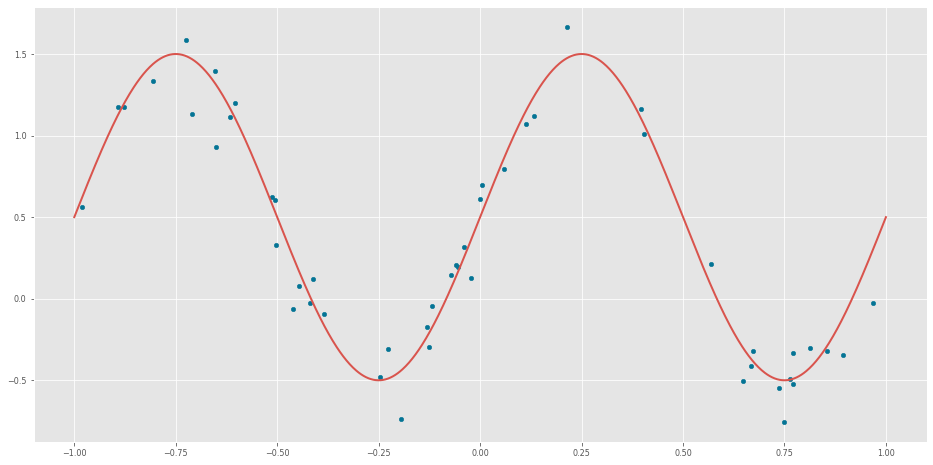

In [9]:
t2 = g(X, noise_variance=1/beta)
y2 = g(x, noise_variance=0)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, y2, linewidth=2, color=colors[2])
plt.show()

### Basis functions

For straight line fitting, a model that is linear in its input variable $x$ is sufficient. Hence, we don't need to transform $x$ with a basis function which is equivalent to using an `identity_basis_function`. For fitting a linear model to a sinusoidal dataset we transform input $x$ with `gaussian_basis_function` and later with `polynomial_basis_function`. These non-linear basis functions are necessary to model the non-linear relationship between input $x$ and target $t$. The design matrix $\boldsymbol\Phi$ can be computed from observations $\mathbf{X}$ and a parametric basis function with function `expand`. This function also prepends a column vector $\mathbf{1}$ according to $\phi_0(x) = 1$.

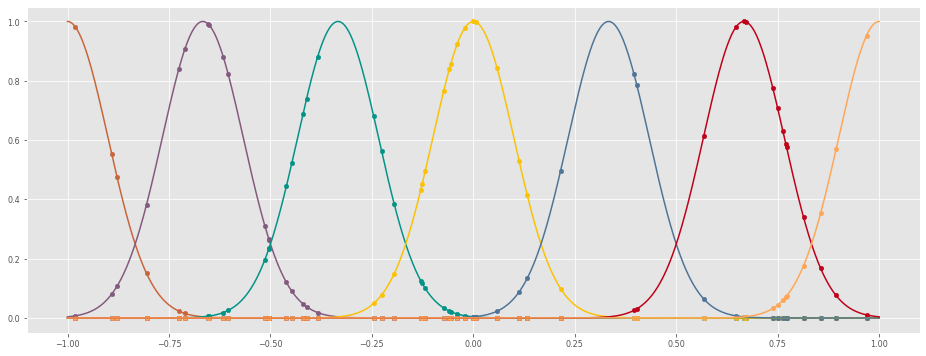

In [10]:
k = 7
mus = np.linspace(-1, 1, k)
fig = plt.figure(figsize=(16,6))
plt.scatter(X, np.zeros_like(X), s=20, color=colors[1])
for i, mu in enumerate(mus):  
    color_index = (4+i)%len(colors)
    plt.plot(x, partial(gaussian_basis_function, **{'mu':mu, 'sigma':0.1})(x), linewidth=1.5, color=colors[color_index])
    plt.scatter(X, partial(gaussian_basis_function, **{'mu':mu, 'sigma':0.1})(X), s=20, color=colors[color_index])
plt.show()

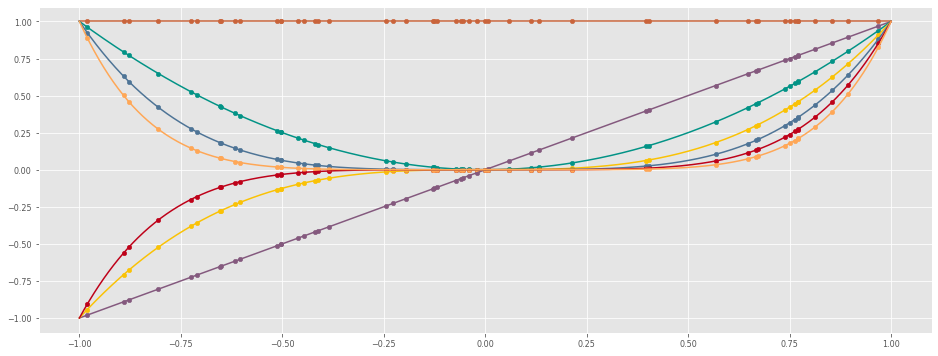

In [11]:
k = 7
powers = np.arange(k)
fig = plt.figure(figsize=(16,6))
for i, power in enumerate(powers):  
    color_index = (4+i)%len(colors)
    plt.plot(x, partial(polynomial_basis_function, **{'power':power})(x), linewidth=1.5, color=colors[color_index])
    plt.scatter(X, partial(polynomial_basis_function, **{'power':power})(X), s=20, color=colors[color_index])
plt.show()

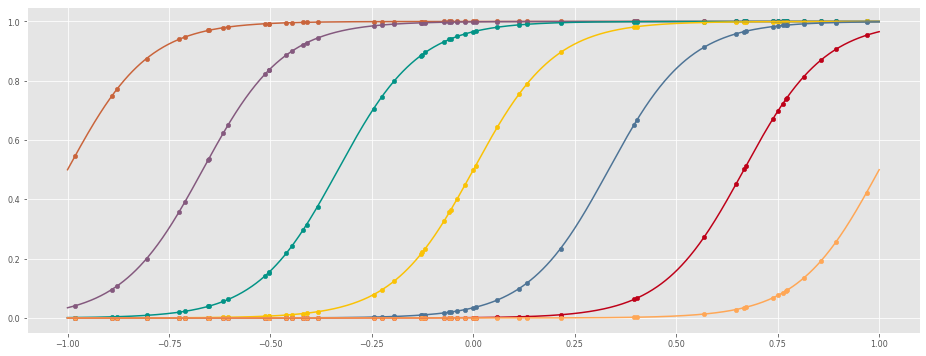

In [12]:
k = 7
mus = np.linspace(-1, 1, k)
fig = plt.figure(figsize=(16,6))
for i, mu in enumerate(mus):  
    color_index = (4+i)%len(colors)
    plt.plot(x, partial(sigmoid_basis_function, **{'mu':mu, 'sigma':0.1})(x), linewidth=1.5, color=colors[color_index])
    plt.scatter(X, partial(sigmoid_basis_function, **{'mu':mu, 'sigma':0.1})(X), s=20, color=colors[color_index])
plt.show()

## Empirical risk minimization

According to this approach, a set $\mathcal{H}$ of possible prediction functions is defined, and the one which minimizes the empirical risk 
$$
\overline{\mathcal{R}}(h; \mathbf{X},\mathbf{t})=\frac{1}{n}\sum_{i=1}^nL(h(\mathbf{x}_i),t_i)
$$

is selected. That is,

$$
\hat{h}=\underset{h\in\mathcal{H}}{\mathrm{argmin}}\;\overline{\mathcal{R}}(h;\mathbf{X},\mathbf{t})
$$

where $L(x_1,x_2)$ is a suitably defined `loss function`.

In the case considered here, we assume that:
- the set of hypotheses $\mathcal{H}$ is a set of parametric linear functions $\sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x})}=\mathbf\phi(\mathbf{x})^T\mathbf{w}$
- the loss function is the `squared residue` $(h(\mathbf{x})-t)^2$, which implies that the empirical risk minimization is defined as 
$$
\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w}; \mathbf{X},\mathbf{t})=\frac{1}{n}\sum_{i=1}^n\left(\sum_{j=0}^{m-1}{w_j \phi_j(\mathbf{x}_i)}-t_i\right)^2=\frac{1}{n}\sum_{i=1}^n\left(\mathbf\phi(\mathbf{x}_i)^T\mathbf{w}-t_i\right)^2=
{1 \over n} \lVert \mathbf\Phi \mathbf{w} - \mathbf{t}\rVert^2
$$

where the *design matrix* $\boldsymbol\Phi$ is defined as
$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{m-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{m-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_n) &  \phi_1(\mathbf{x}_n) & \cdots & \phi_{m-1}(\mathbf{x}_n)
\end{pmatrix}
$$

and the minimization is performed in the space $\mathbb{R}^m$ of parameters
$$
\hat{\mathbf{w}}=\underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmin}}\;\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w};\Phi,\mathbf{t})
$$

The resulting prediction function is $\hat{h}(\mathbf{x})=\mathbf\phi(\mathbf{x})^T\hat{\mathbf{w}}$.

Under the given hypotheses, the empirical risk is a quadratic function with gradient

$$
\nabla_\mathbf{w}\overline{\mathcal{R}}_\mathbf{\phi}(\mathbf{w}; \boldsymbol\Phi,\mathbf{t})=\frac{2}{n}\sum_{i=1}^n\left(\boldsymbol\phi(\mathbf{x}_i)^T\mathbf{w}-t_i\right)\boldsymbol\phi(\mathbf{x}_i)
$$

The function has only one local minimum, which is then also global, corresponding to the parameter value
$$
\hat{\mathbf{w}}=(\boldsymbol\Phi^{T}\boldsymbol\Phi)^{-1}\boldsymbol\Phi^{T}\mathbf{t}
$$

In [13]:
def erm(X, t, args):
    X_ = expand(X, **args)
    return np.dot(np.dot(np.linalg.inv(np.dot(X_.T, X_)), X_.T), t)

In [14]:
def predict(X, w, args):
    y = np.dot(expand(x, **args), w)
    if np.isscalar(x):
        return y.item()
    else:
        return y

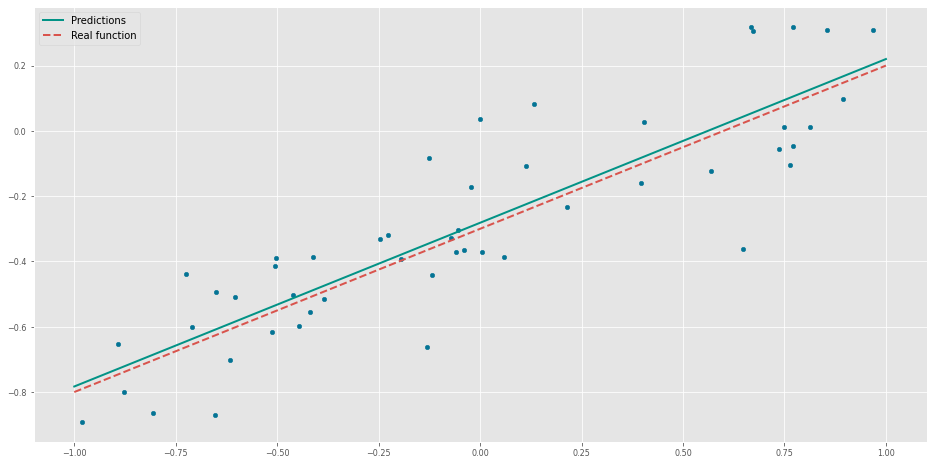

In [15]:
args = {}
w_star = erm(X, t1, args)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

In [16]:
k = 10
mus = np.linspace(-1, 1, k)
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

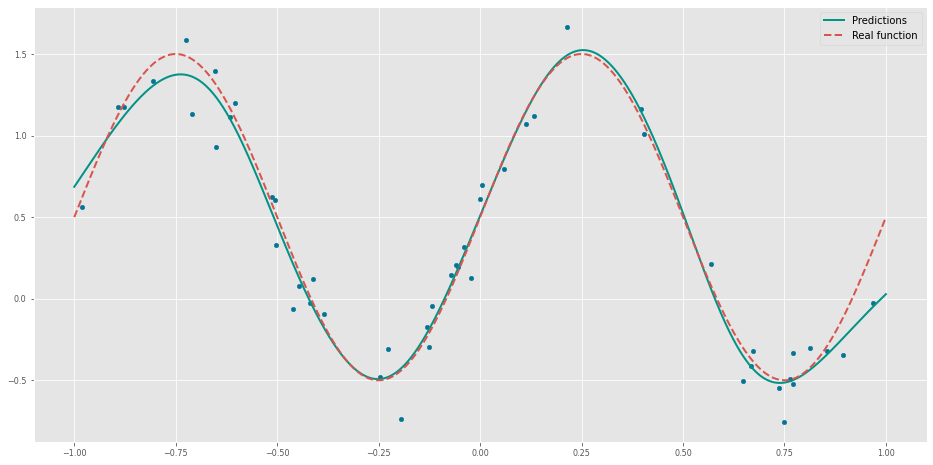

In [17]:
w_star = erm(X, t2, args)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

A *regularization* term can be considered to control overfitting, for example as an additional sum of the squared coefficients. This particular form of regularization is known as *L2 regularization* or *weight decay* as it limits the magnitude of weights $w_j$. In the case of regression, it is also denoted as *ridge regression*.
$$
\sum_{k=1}^mw_i^2=\lVert\mathbf{w}\rVert^2
$$
The resulting loss function is
$$
\overline{\mathcal{R}}_\phi(\mathbf{w}; \boldsymbol\Phi,\mathbf{t}, \lambda)=\frac{1}{n}\sum_{i=1}^n\left(\boldsymbol{\phi}(\mathbf{x}_i)^T\mathbf{w}-t_i\right)^2+\frac{\lambda}{2}\sum_{k=1}^mw_i^2=
{1 \over n} \lVert \boldsymbol\Phi \mathbf{w} - \mathbf{t}\rVert^2+\frac{\lambda}{2}\lVert\mathbf{w}\rVert^2
$$
where $\lambda$ is an hyper-parameter controlling the amount of regularization applied (larger $\lambda$, larger regularization).

In this case, the loss function, has still a unique minimum, corresponding to the parameter value
$$
\hat{\mathbf{w}}=(\boldsymbol\Phi^{T}\boldsymbol\Phi+\lambda\mathbf{I})^{-1}\boldsymbol\Phi^{T}\mathbf{t}
$$



In [18]:
def erm_reg(X, t, l, args):
    X_ = expand(X, **args)
    m = X_.shape[1]
    return np.dot(np.dot(np.linalg.inv(np.dot(X_.T, X_)+l*np.eye(m)), X_.T), t)

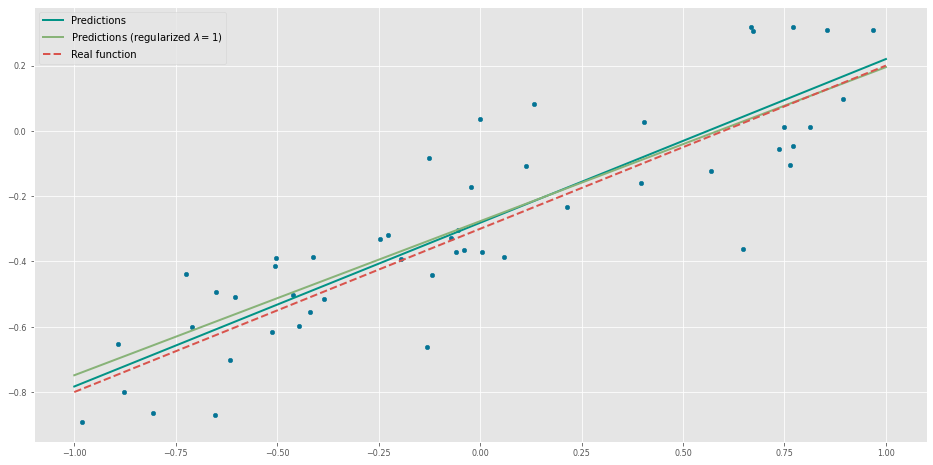

In [19]:
args = {}
l = 1
w_star = erm(X, t1, args)
w_star_reg = erm_reg(X, t1, l, args)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict(x,w_star, args), linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, predict(x,w_star_reg, args), linewidth=2, color=colors[3], label=f'Predictions (regularized $\lambda={l}$)')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

## Probabilistic methods

According to this approach, a family of probabilistic models is considered, modeling the joint distribution $p(\mathbf{x}, t|\mathbf{w})$. From this distribution,
the `predictive distribution' $p(t|\mathbf{x}, \mathbf{X}, \mathbf{t})$ of the target given the element (and the set of examples) is derived.

Since $p(\mathbf{x}, t|\mathbf{w})=p(t|\mathbf{x},\mathbf{w})p(\mathbf{x}|\mathbf{w})$, and since $p(\mathbf{x}|\mathbf{w})$ is in general assumed uniform, only the conditional probability
$p(t|\mathbf{x},\mathbf{w})$ is considered and the parametric probabilistic model is defined with respect to this distribution.

A first general idea, here, is to compute a value $\hat{\mathbf{w}}_{ML}$ which maximizes the probability of the available data $\mathbf{X}, \mathbf{t}$. This probability, assuming observations are independent and uniformly distributed, is

$$
\hat{\mathbf{w}}_{ML} = \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; p(\mathbf{X}, \mathbf{t}|\mathbf{w})=  \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(\mathbf{x}_i, t_i|\mathbf{w})=\underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(t_i|\mathbf{x}_i,\mathbf{w})p(\mathbf{x}_i|\mathbf{w}) = \underset{\mathbf{w}\in\mathbb{R}^m}{\mathrm{argmax}}\; \prod_{i=1}^np(t_i|\mathbf{x}_i,\mathbf{w})
$$

The predictive distribution is then $p(t|\mathbf{x}, \mathbf{X}, \mathbf{t})=p(t|\mathbf{x}, \hat{\mathbf{w}})$.

Note that, in general, it should be 
$$
p(t|\mathbf{x}, \mathbf{X}, \mathbf{t}) = \int p(t, \mathbf{w}|\mathbf{x}, \mathbf{X}, \mathbf{t})d\mathbf{w}= \int p(t|\mathbf{x}, \mathbf{w}, \mathbf{X}, \mathbf{t})p(\mathbf{w}|\mathbf{x}, \mathbf{X}, \mathbf{t})d\mathbf{w}= \int p(t|\mathbf{x}, \mathbf{w})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w}
$$
As shown in the graphical model in figure, we assume that 
$t$ is independent from $\mathbf{X}$ and $\mathbf{t}$ if $\mathbf{w}$ and $\mathbf{x}$ are given, and that $\mathbf{w}$ is independent from $\mathbf{x}$.

<img src="gm_lr.png" height="100">

Choosing only a specific value $\hat{\mathbf{w}}$ of $\mathbf{w}$ results into
$$
p(t|\mathbf{x}, \mathbf{X}, \mathbf{t}) = \int p(t|\mathbf{x}, \mathbf{w})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w} \simeq \int p(t|\mathbf{x}, \hat{\mathbf{w}})p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w}= p(t|\mathbf{x}, \hat{\mathbf{w}}) \int p(\mathbf{w}|\mathbf{X}, \mathbf{t})d\mathbf{w} = p(t|\mathbf{x}, \hat{\mathbf{w}})
$$


The probabilistic model considered here assumes that the target variable $t$ of an observation $\mathbf{x}$ is given by applying a deterministic function $h(\mathbf{x}, \mathbf{w})$ and adding to the result a random noise $\varepsilon$. 

$$
t = h(\mathbf{x}, \mathbf{w}) + \varepsilon \tag{2}
$$

We make the assumption that the noise is normally distributed i.e. it follows a Gaussian distribution with zero mean and given, but unknown, precision (= inverse variance) $\beta$. The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\mathbf{x}$ can therefore be written as

$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert h(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - h(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

The mean of this distribution is the `regression function` $h(\mathbf{x}, \mathbf{w})$. 

## Likelihood function

Assuming a set of basis function $\boldsymbol\phi(\mathbf{x})$ is applied, the joint conditional probability of targets $\mathbf{t}$ given $\mathbf{X}$ is

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{n}{\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \tag{4}
$$

This is a function of parameters $\mathbf{w}$ and $\beta$ and is called the *likelihood function*. The logarithm (the base is not relevant here) of the likelihood function can be written as 

$$
\log p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
{n \over 2} \log \beta - 
{n \over 2} \log {2 \pi} - 
\beta E_D(\mathbf{w}) \tag{5}
$$

where $E_D(\mathbf{w})$ is the sum-of-squares error function

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{n}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2 \tag{6}
$$

## Maximum likelihood

Maximizing the log likelihood is clearly equivalent to minimizing the empirical risk defined above w.r.t. $\mathbf{w}$. Maximum likelihood estimation can lead to severe over-fitting if complex models (e.g. polynomial regression models of high order) are fit to datasets of limited size. A common approach to prevent over-fitting is to add a regularization term to the error function. As we will see shortly, this regularization term arises naturally when following a Bayesian approach (more precisely, when defining a prior distribution over parameters $\mathbf{w}$). 

Actually, an estimate of the uncertainty can also be derived by maximizing the likelihood with respect to $\beta$, which results into 

$$
\hat{\beta}^{-1}=\frac{1}{n}\sum_{i=1}^n\left(t_i-h(\mathbf{x}_i,\hat{\mathbf{w}})\right)^2= \frac{1}{n}\sum_{i=1}^n\left(t_i-\hat{\mathbf{w}}^T\mathbf{\phi}(\mathbf{x})\right)^2
$$

In [20]:
def mle(X, t, bf=None, bf_args_list=None):
    X_ = expand(X, bf, bf_args_list)
    return np.dot(np.dot(np.linalg.inv(np.dot(X_.T, X_)), X_.T), t)

In [21]:
def std_ml(X, t, w, args):
    y = np.dot(expand(X, **args), w)
    return np.sqrt(np.mean((t-y)**2))

In [22]:
args1 = {}

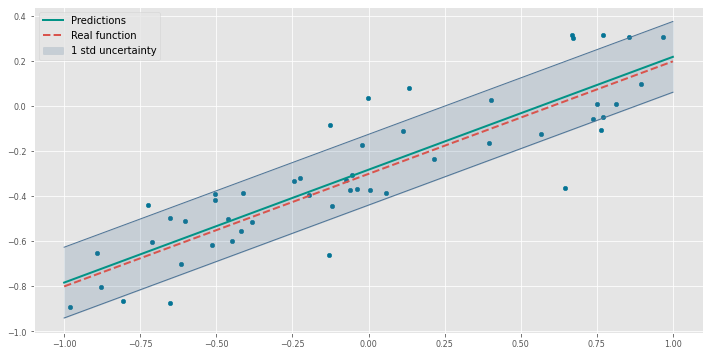

In [23]:
w_ML = erm(X, t1, args1)
std_ML = std_ml(X, t1, w_ML, args1)
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t1, s=20, color=colors[1])
pred = predict(x,w_ML, args1)
plt.plot(x, pred, linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, pred-std_ML, linewidth=1, color=colors[8])
plt.plot(x, pred+std_ML, linewidth=1, color=colors[8])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.fill_between(x.ravel(), (pred-std_ML).ravel(), (pred+std_ML).ravel(), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.legend()
plt.show()

In [24]:
k = 10
mus = np.linspace(-1, 1, k)
args2 = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

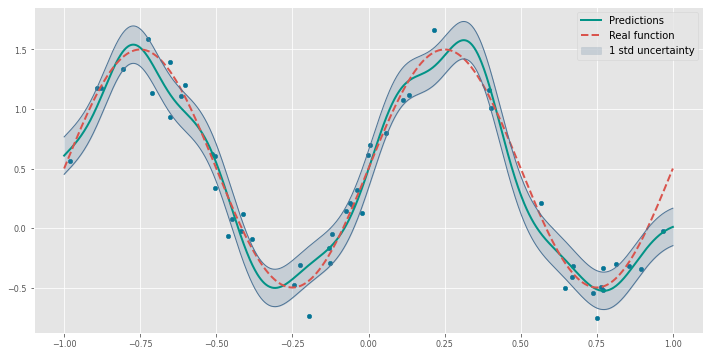

In [25]:
w_ML = erm(X, t2, args2)
fig = plt.figure(figsize=(12,6))
plt.scatter(X, t2, s=20, color=colors[1])
pred = predict(x,w_ML, args2)
plt.plot(x, pred, linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.plot(x, pred-std_ML, linewidth=1, color=colors[8])
plt.plot(x, pred+std_ML, linewidth=1, color=colors[8])
plt.fill_between(x.T.squeeze(), (pred-std_ML).ravel(), (pred+std_ML).ravel(), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.legend()
plt.show()

## Bayesian approach

### Prior and posterior distribution

For a Bayesian treatment of linear regression we need a prior probability distribution over model parameters $\mathbf{w}$. For reasons of simplicity, we will use here an isotropic Gaussian distribution over parameters $\mathbf{w}$ with zero mean:

$$
p(\mathbf{w} \lvert \alpha) = \mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I}) \tag{8}
$$

An isotropic Gaussian distribution has a diagonal covariance matrix where all diagonal elements have the same variance $\alpha^{-1}$ ($\alpha$ is the precision of the prior). A zero mean favors small(er) values of parameters $w_j$ a priori. 

$$
\alpha^{-1}\mathbf{I} = 
\begin{pmatrix}
\alpha^{-1} &  0 & \cdots & 0 \\ 
0 &  \alpha^{-1} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 &  0 & \cdots & \alpha^{-1}
\end{pmatrix}
$$

In [26]:
def plot_bivariate_gaussian(mean, cov, resolution = 100):
    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)
    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1), cmap='rainbow')
    plt.xticks([-1,-.5,0,.5,1])
    plt.yticks([-1,-.5,0,.5,1])
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')

In [27]:
alpha = 10
cov = 1/alpha*np.eye(2, dtype=int)
mean = np.zeros(2)

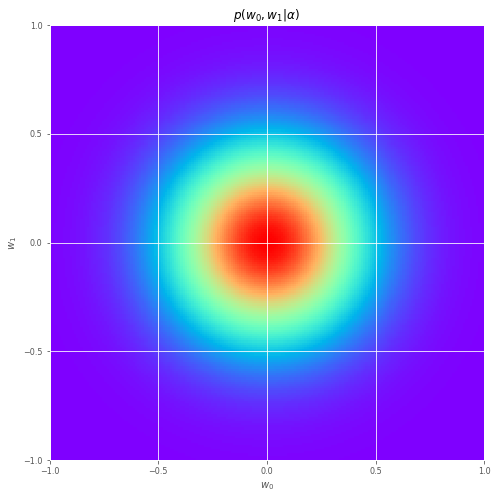

In [28]:
plt.figure(figsize=(8,8))
plot_bivariate_gaussian(mean, cov, 200)
plt.title(r'$p(w_0,w_1|\alpha)$', fontsize=12)
plt.show()

The prior is *conjugate* to the likelihood $p(\mathbf{t} \lvert \mathbf{w}, \beta)$: that is, the posterior distribution has the same functional form as the prior i.e. it is also a Gaussian. In this special case, the posterior has an analytical solution with the following sufficient statistics 

$$
\mathbf{m}_n = \beta \mathbf{S}_n \Phi^T \mathbf{t}  \tag{9}
$$

$$
\mathbf{S}_n = \left(\alpha\mathbf{I} + \beta \Phi^T \Phi\right)^{-1}  \tag{10}
$$


$(9)$ is the mean vector of the posterior and $(10)$ the inverse covariance matrix (= precision matrix). Hence, the posterior distribution can be written as

$$
p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = \mathcal{N}(\mathbf{w} \lvert \mathbf{m}_n, \mathbf{S}_n) \tag{11}
$$

For the moment, we assume that the values of $\alpha$ and $\beta$ are known. Since the posterior is proportional to the product of likelihood and prior, the log of the posterior distribution is proportional to the sum of the log likelihood and the log of the prior

$$
\log p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
-\beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} \tag{12}
$$

where, as defined by $(6)$,

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{n}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2
$$

and moreover

$$
E_W(\mathbf{w}) = {1 \over 2} \mathbf{w}^T \mathbf{w} =
{1 \over 2} \lVert \mathbf{w} \rVert^2\tag{13}
$$

Maximizing the log posterior w.r.t. $\mathbf{w}$ gives the *maximum-a-posteriori* (MAP) estimate of $\mathbf{w}$. Maximizing the log posterior is equivalent to minimizing the sum-of-squares error function $E_D$ plus a quadratic regularization term $E_W$, that is to a ridge regression. The contribution of the regularization term is now determined by the ratio $\alpha / \beta$, since the loss function to be minimzed can be written as 

$$
\sum_{i=1}^n\left(\boldsymbol\phi(\mathbf{x}_i)^T\mathbf{w}-t_i\right)^2+\frac{\alpha}{\beta}\sum_{k=1}^mw_i^2=
\lVert \boldsymbol\Phi \mathbf{w} - \mathbf{t}\rVert^2+\frac{\alpha}{\beta}\lVert\mathbf{w}\rVert^2
$$

which is minimal for
$$
\hat{\mathbf{w}}=(\boldsymbol\Phi^{T}\boldsymbol\Phi+\frac{\alpha}{\beta}\mathbf{I})^{-1}\boldsymbol\Phi^{T}\mathbf{t}
$$

### Posterior predictive distribution

In order to make a prediction $t$ at a new location $\mathbf{x}$ we use the posterior predictive distribution which is defined as

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) d\mathbf{w}} \tag{14}
$$

The posterior predictive distribution includes uncertainty about parameters $\mathbf{w}$ into predictions by weighting the conditional distribution $p(t \lvert \mathbf{x}, \mathbf{w}, \beta)$ with the posterior probability of weights $p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta)$ over the entire weight parameter space. By using the predictive distribution we're not only getting the expected value of $t$ at a new location $\mathbf{x}$ but also the uncertainty for that prediction. In our special case, the posterior predictive distribution is a Gaussian distribution

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\mathcal{N}(t \lvert \mathbf{m}_n^T \boldsymbol\phi(\mathbf{x}), \sigma_n^2(\mathbf{x})) \tag{15}
$$

where mean $\mathbf{m}_n^T \boldsymbol\phi(\mathbf{x})$ is the regression function after $n$ observations and $\sigma_n^2(\mathbf{x})$ is the corresponding predictive variance

$$
\sigma_n^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^T \mathbf{S}_n \boldsymbol\phi(\mathbf{x}) \tag{16}
$$

The first term in $(16)$ represents the inherent noise in the data and the second term covers the uncertainty about parameters $\mathbf{w}$. So far, we have assumed that the values of $\alpha$ and $\beta$ are known. 


In [29]:
def posterior_ss(Phi, t, alpha, beta):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)
    return m_N, S_N


def posterior_predictive_ss(phi, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = phi.dot(m_N)
    y_var = 1 / beta + np.sum(phi.dot(S_N)*phi, axis=1)
    return y, y_var

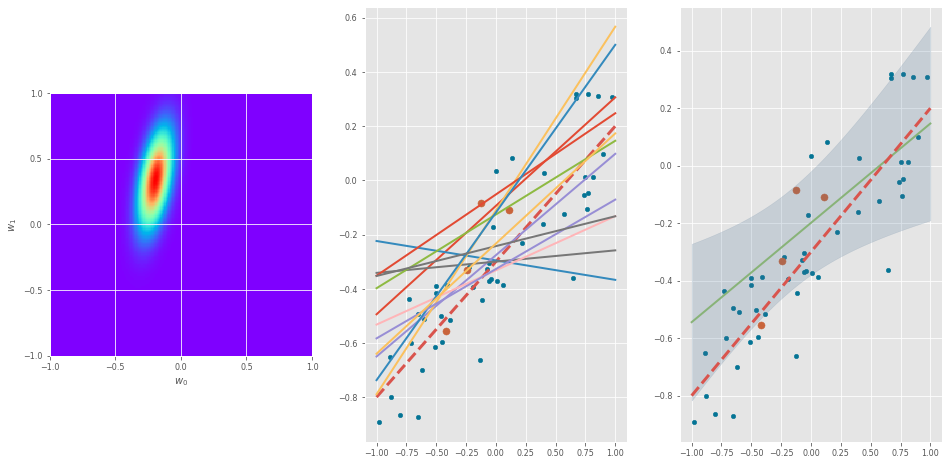

In [30]:
nexamples = 4
nsamples = 12
args1 = {}
X_ = expand(X[:nexamples], **args1)
mean_post, cov_post = posterior_ss(X_, t1[:nexamples], alpha, beta)
w_samples = np.random.multivariate_normal(mean_post.ravel(), cov_post, nsamples)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plot_bivariate_gaussian(mean_post, cov_post, 200)
plt.subplot(1,3,2)
plt.scatter(X, t1, s=20, color=colors[1])
plt.scatter(X[:nexamples], t1[:nexamples], s=50, color=colors[4])
plt.plot(x, y1, linestyle='dashed', linewidth=3, color=colors[2])
for w in w_samples:
    plt.plot(x, np.dot(expand(x, **args1), w.reshape(-1,1)), linewidth=2)
plt.subplot(1,3,3)
y, y_var = posterior_predictive_ss(expand(x, **args1), mean_post, cov_post, beta)
plt.plot(x,y, color=colors[3], label='prediction')
plt.scatter(X, t1, s=20, color=colors[1])
plt.scatter(X[:nexamples], t1[:nexamples], s=50, color=colors[4])
plt.plot(x, y1, linestyle='dashed', linewidth=3, color=colors[2])
plt.fill_between(x.ravel(), y.ravel()-np.sqrt(y_var), y.ravel()+np.sqrt(y_var), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.show()

In [31]:
k = 10
mus = np.linspace(-1, 1, k)
args2 = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

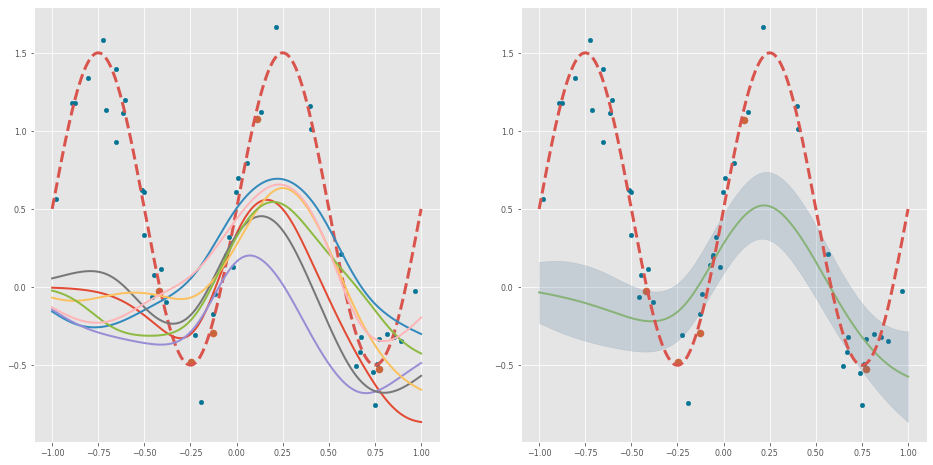

In [32]:
nexamples = 5
nsamples = 7
X_ = expand(X[:nexamples], **args2)
mean_post, cov_post = posterior_ss(X_, t2[:nexamples], alpha, beta)
w_samples = np.random.multivariate_normal(mean_post.ravel(), cov_post, nsamples)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(X, t2, s=20, color=colors[1])
plt.scatter(X[:nexamples], t2[:nexamples], s=50, color=colors[4])
plt.plot(x, y2, linewidth=3, color=colors[2], linestyle='dashed', label='Real function')
for w in w_samples:
    plt.plot(x, np.dot(expand(x, **args2), w.reshape(-1,1)), linewidth=2)
plt.subplot(1,2,2)
y, y_var = posterior_predictive_ss(expand(x, **args2), mean_post, cov_post, beta)
plt.plot(x,y,color=colors[3],  label='prediction')

plt.plot(x, y2, linewidth=3, color=colors[2], linestyle='dashed', label='Real function')
plt.scatter(X, t2, s=20, color=colors[1])
plt.scatter(X[:nexamples], t2[:nexamples], s=50, color=colors[4])
plt.fill_between(x.ravel(), y.ravel()-np.sqrt(y_var), y.ravel()+np.sqrt(y_var), color=colors[8], alpha=.2, label='1 std uncertainty')
plt.show()

As the size of the dataset increases the posterior sample variance and the prediction uncertainty decreases. Also, regions with less observations have higher prediction uncertainty.

### Marginal likelihood and evidence

In a fully Bayesian treatment, however, we should define priors over $\alpha$ and $\beta$ and use the corresponding posteriors to additionally include uncertainties about $\alpha$ and $\beta$ into predictions. 

$$
p(t \lvert \mathbf{x}, \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) p(\alpha) p(\beta)d\mathbf{w}}\;d\alpha\;d\beta
$$

Unfortunately, complete integration over all three parameters $\mathbf{w}$, $\alpha$ and $\beta$ is analytically intractable and we have to use another approach. 

Estimates for $\alpha$ and $\beta$ can alternatively be obtained by considering the *marginal likelihood*, resulting by integrating out the parameters $\mathbf{w}$ from the likelihood

$$
p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) =
\int{p(\mathbf{X}, \mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} 
$$

since $p(\alpha, \beta|\mathbf{X}, \mathbf{t})\propto p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) p(\alpha, \beta)$, if we assume a uniform prior $p(\alpha,\beta)$ over the hyper-parameters then we may compare the probabilities of two pairs $\alpha_1, \beta_1$, given the training set $\mathbf{X}, \mathbf{t}$ by comparing the corresponding marginal likelihoods

$$
\frac{p(\alpha_1, \beta_1|\mathbf{X}, \mathbf{t})}{p(\alpha_2, \beta_2|\mathbf{X}, \mathbf{t})}=\frac{p(\mathbf{X}, \mathbf{t}|\alpha_1, \beta_1)}{p(\mathbf{X}, \mathbf{t}|\alpha_2, \beta_2)}
$$
this is called *Bayes factor*.

Since moreover $p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta)=p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)p(\mathbf{X} \lvert \alpha, \beta)$, if we make the usual hypothesis that $\mathbf{X}$ is independent from the model and its parameters (and hyper-parameters) it results 

$$
p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta)\propto p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)
$$ 

where the second term is the *evidence* 

$$
p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta) =
\int{p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} 
$$

which is related to likelihood, prior, and posterior by Bayes' theorem

$$
p(\mathbf{w} \lvert \mathbf{X}, \mathbf{t}, \alpha, \beta) = 
{p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) \over p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta)}  
$$

Under these conditions, we may compare the probabilities of two pairs $\alpha_1, \beta_1$, given the training set $\mathbf{X}, \mathbf{t}$ by comparing the corresponding evidences

$$
\frac{p(\alpha_1, \beta_1|\mathbf{X}, \mathbf{t})}{p(\alpha_2, \beta_2|\mathbf{X}, \mathbf{t})}=\frac{p(\mathbf{t}|\mathbf{X}, \alpha_1, \beta_1)}{p(\mathbf{t}|\mathbf{X}, \alpha_2, \beta_2)}
$$

Integration over model parameters makes models of different complexity directly comparable, for example by comparing their evidences on training data alone without needing a validation set. 


In the framework of gaussian models for prior and likelihood considered here, the log of the evidence is given by

$$
\log p(\mathbf{t} \lvert \mathbf{X}, \alpha, \beta) = \frac{m}{2}\log\alpha + \frac{n}{2}\log\beta -
E(\mathbf{m}_n)-\frac{1}{2}\log\lvert\mathbf{S}_n^{-1}\rvert - \frac{n}{2}\log\frac{2}{\pi} \tag{18}
$$

where

$$
E(\mathbf{m}_n) = \frac{\beta}{2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{m}_n \rVert^2 +
\frac{\alpha}{2} \mathbf{m}_n^T \mathbf{m}_n \tag{19}
$$


In [33]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape
    m_N, S_N = posterior_ss(Phi, t, alpha, beta)
    S_N_inv = np.linalg.inv(S_N)
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    score = M*np.log(alpha) + N*np.log(beta) - E_D - E_W - np.log(np.linalg.det(S_N_inv)) - N*np.log(2*np.pi)

    return 0.5 * score

#### Maximization

Since $p(\alpha, \beta|\mathbf{X}, \mathbf{t})\propto p(\mathbf{X}, \mathbf{t} \lvert \alpha, \beta) p(\alpha, \beta)$
maximizing the marginal likelihood corresponds to maximizing the probability of the hyper-parameters given the training set.

The approach of maximizing the marginal likelihood or, equivalently, the evidence w.r.t. $\alpha$ and $\beta$ is known as *empirical Bayes*. It can be shown that this is a good approximation for a fully Bayesian treatment if the posterior for $\alpha$ and $\beta$ is sharply peaked around the most probable value and the prior is relatively flat which is often a reasonable assumption. 

Integrating over model parameters or using a good approximation for it allows us to estimate values for $\alpha$ and $\beta$, and hence the regularization strength $\alpha / \beta$, from training data alone i.e. without using a validation set.

The sets of gaussian basis function models are compared on the basis of the log marginal likelihood computed with a dataset of examples observations. We still assume that the values of $\alpha$ and $\beta$ are known and will see in the next section how they can be inferred by maximizing the log marginal likelihood. When plotting the posterior predictive distribution of the polynomial models we can see that a model of degree 5 has already sufficient complexity to explain the data reasonably well.

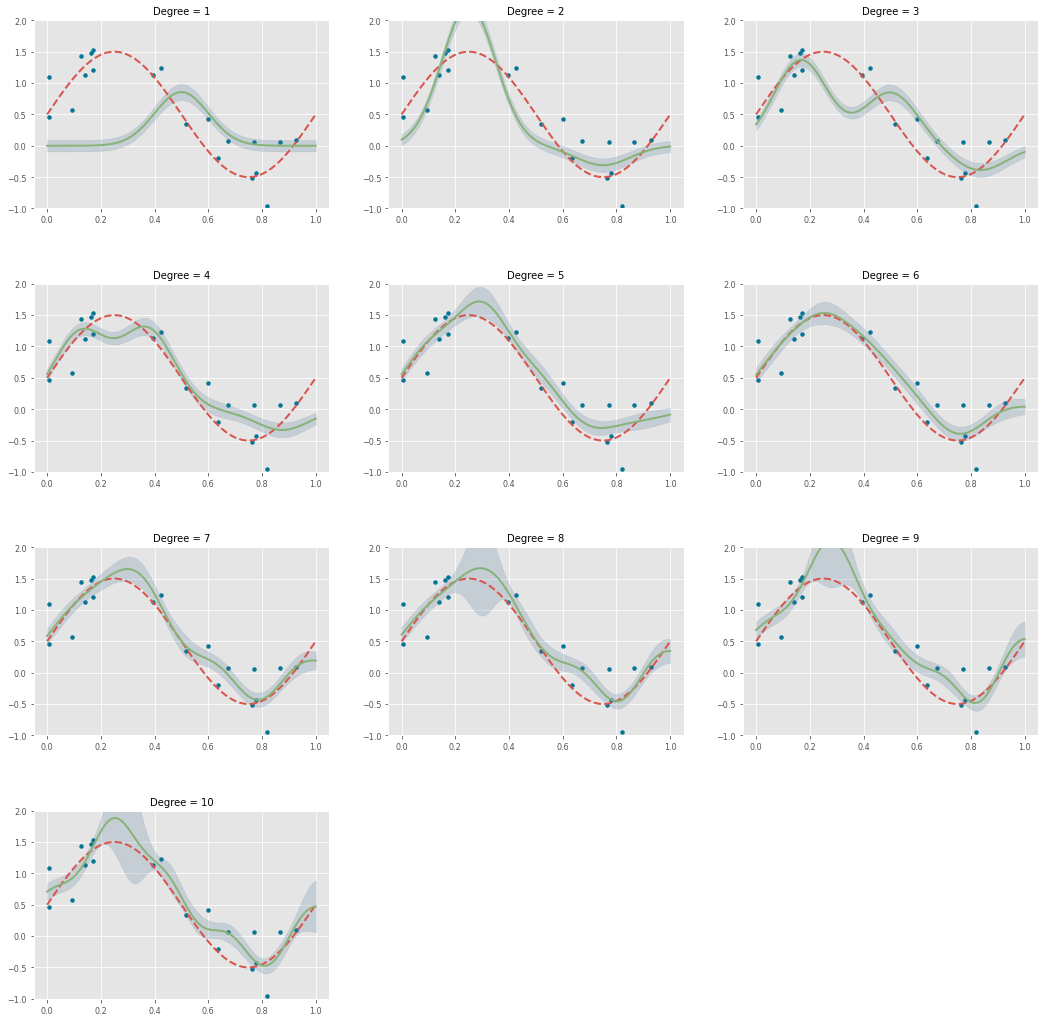

In [34]:
beta = 1/(0.3 ** 2)
alpha = 0.005

nexamples = 20

x0 = np.linspace(0, 1, 1000).reshape(-1, 1)
y0 = g(x0, noise_variance=0).T

X_s = np.random.rand(50, 1)
X0 = X_s[:nexamples]
t0 = g(X0, noise_variance=1/beta)

degree = 9
degrees = range(degree + 1)

m = 10
rows = int(m/3)+1

plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.4)
for d in range(1, m+1):
    mus = np.linspace(x0[0], x0[-1], d+1)
    args = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mus[k]+.5*(mus[k+1]-mus[k])} for k in range(len(mus)-1)]}
    X_ = expand(X0, **args)
    m_N, S_N = posterior_ss(X_, t0, alpha, beta)
    x_ = expand(x0, **args)
    y, y_var = posterior_predictive_ss(x_, m_N, S_N, beta)
    plt.subplot(rows, 3, d)
    plt.scatter(X0,t0, s=15, color=colors[1])
    plt.plot(x0,y0.ravel(), color=colors[2], linestyle='dashed')
    plt.plot(x0, y, color=colors[3])
    plt.fill_between(x0.ravel(),y.ravel()-y_var.ravel(),y.ravel()+y_var.ravel(), color=colors[8], alpha=.2)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)


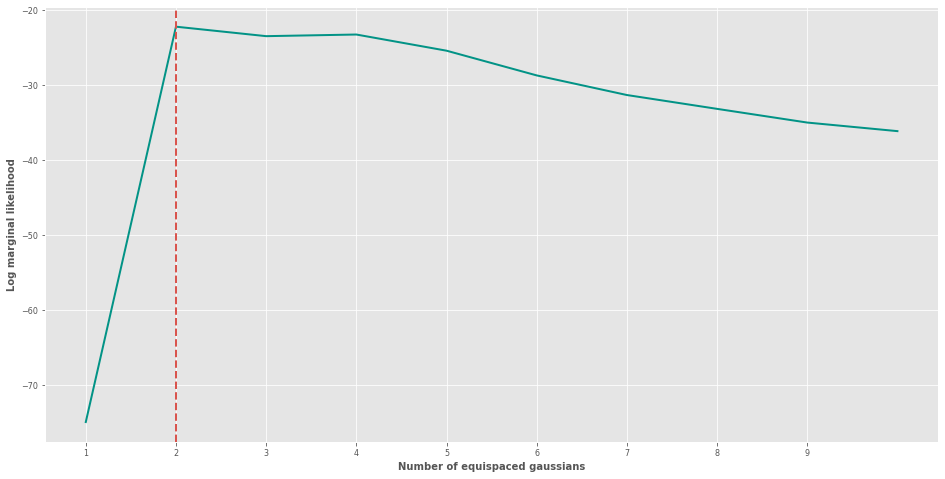

In [35]:
mlls = []

for d in range(1, m+1):
    mus = np.linspace(x0[0], x0[-1], d+1)
    args = {'bf': gaussian_basis_function, 'bf_args_list':[{'mu':mus[k]+.5*(mus[k+1]-mus[k])} for k in range(len(mus)-1)]}
    X_ = expand(X0, **args)
    mll = log_marginal_likelihood(X_, t0, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)+1
plt.plot(range(1,m+1), mlls, color=colors[6])
plt.axvline(x=degree_max, linestyle='dashed', color=colors[2], lw=2)
plt.xticks(range(1, m))
plt.xlabel('Number of equispaced gaussians')
plt.ylabel('Log marginal likelihood');

In the case considered here, maximization of the log evidence (and of the log marginal likelihood) w.r.t. $\alpha$ and $\beta$ gives the following implicit solutions

$$
\alpha = \frac{\gamma}{\mathbf{m}_n^T \mathbf{m}_n} \tag{21}
$$

and 

$$
\frac{1}{\beta} = \frac{1}{n-\gamma} \sum_{i=1}^{n}(t_i - \mathbf{m}_n^T \boldsymbol\phi(\mathbf{x}_i))^2 \tag{22}
$$

where 

$$
\gamma = \sum_{i=0}^{m-1} \frac{\lambda_i}{\alpha+\lambda_i} \tag{23}
$$


and $\lambda_i$ are the *eigenvalues* of $\beta \boldsymbol\Phi^T \boldsymbol\Phi$. The solutions are implicit because both $\alpha$ and $\beta$ depend on $\gamma$ and $\gamma$ depend on both $\alpha$ and $\beta$. Solutions for $\alpha$ and $\beta$ can therefore be obtained by starting with initial values for these parameters and then iterating over the above equations until convergence.

In [36]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    N, M = Phi.shape
    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))
    beta = beta_0
    alpha = alpha_0
    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha
        eigenvalues = eigenvalues_0*beta
        m_N, S_N = posterior_ss(Phi, t, alpha, beta)
        gamma = np.sum(eigenvalues/(eigenvalues + alpha))
        alpha = gamma/np.sum(m_N**2)
        beta_inv = 1/(N-gamma)*np.sum((t-Phi.dot(m_N))**2)
        beta =1/beta_inv
        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N
    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [37]:
N = 30

degree = 4

Xc = np.linspace(0, 1, N).reshape(-1, 1)
tc = g(Xc, noise_variance=0.3 ** 2)

args = {'bf': polynomial_basis_function, 'bf_args_list':[{'power':k} for k in range(1, degree + 1)]}
Phi = expand(Xc, **args)

alpha, beta, m_N, S_N = fit(Phi, tc, rtol=1e-5, verbose=True)
print(f'alpha* = {alpha:5.3f}')
print(f'beta* = {beta:5.3f}')

Convergence after 25 iterations.
alpha* = 0.001
beta* = 9.214


In [38]:
X_test = np.random.rand(10, 1)*2-1

Phi_test = expand(X_test, **args)

In [39]:
y_mean, y_var = posterior_predictive_ss(Phi_test, m_N, S_N, beta)

print(f'Prediction mean: {y_mean.ravel()}')
print(f'Prediction std: {np.sqrt(y_var)}')

Prediction mean: [  1.35024272  -2.2260657  -33.29827413  -0.20173018  -6.24427356
 -34.59887029  -0.38992515 -18.51781252  -8.85345477 -73.55025408]
Prediction std: [ 0.34475755  0.43324919  6.4433613   0.34515582  0.96446182  6.7391434
  0.35154437  3.24483577  1.39883363 16.26592863]


## Equivalent kernel
Observe now that the expectation of the predictive distribution 
$$
\mathbf{m}_n^T\mathbf{\phi}(\mathbf{x})=(\beta\mathbf{S}_n\mathbf{\Phi}^{T}\mathbf{t})^T\mathbf{\phi}(\mathbf{x})
$$
can be written also as
$$
\mathbf{\phi}(\mathbf{x})^T\mathbf{m}_n=\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_n\mathbf{\Phi}^{T}\mathbf{t}=\sum_{i=1}^{n}\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_n\mathbf{\phi}(\mathbf{x}_{i})t_{i}
$$

If we assume that the prediction $y(\mathbf{x})$ for $\mathbf{x}$ corresponds to this expectation, then it can be seen as a linear combination $\sum_{i=1}^nw_it_i$ of the target values $t_i$ of the items in the training set, with weights $w_i=\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_N\mathbf{\phi}(\mathbf{x}_{i})$ dependent from the item values $\mathbf{x}_i$ (and from $\mathbf{x}$).

The weight function 
$$
\kappa(\mathbf{x},\mathbf{x}')=\beta\mathbf{\phi}(\mathbf{x})^{T}\mathbf{S}_n\mathbf{\phi}(\mathbf{x}')
$$
is said *equivalent kernel*

In [40]:
def equiv_kernel(x1, x2, X, t, alpha, beta, args):
    phi_1 = expand(x1, **args)
    phi_2 = expand(x2, **args)
    Phi = expand(X, **args)
    _, S = posterior_ss(Phi, t, alpha, beta)
    return beta*(phi_1.dot(S)).dot(phi_2.T)

In [41]:
def predict_equiv_kernel(X_test, X, t, alpha, beta, args):
    return np.sum(np.multiply(t, equiv_kernel(X_test, X, X, t, alpha, beta, args).T), axis=0)

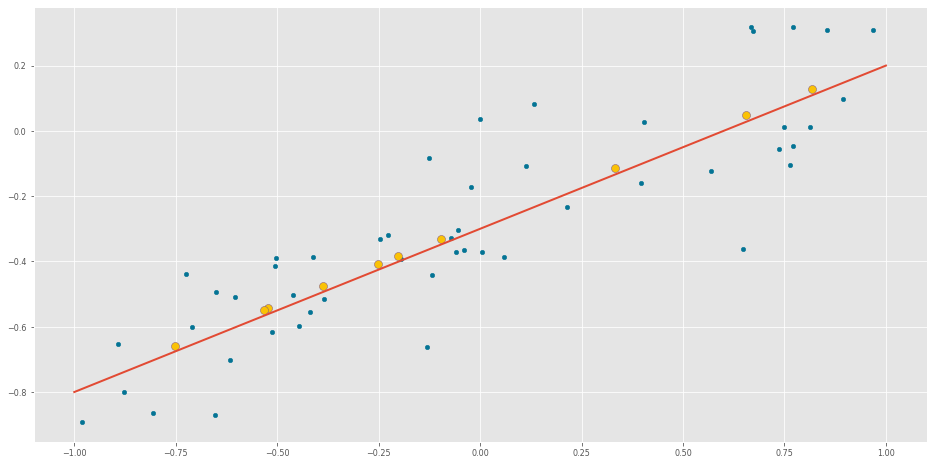

In [42]:
args = {}
plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, y1, linewidth=2)
plt.scatter(X_test, predict_equiv_kernel(X_test, X, t1, alpha, beta, args), color=colors[7], edgecolor=colors[5], marker='o')
plt.show()

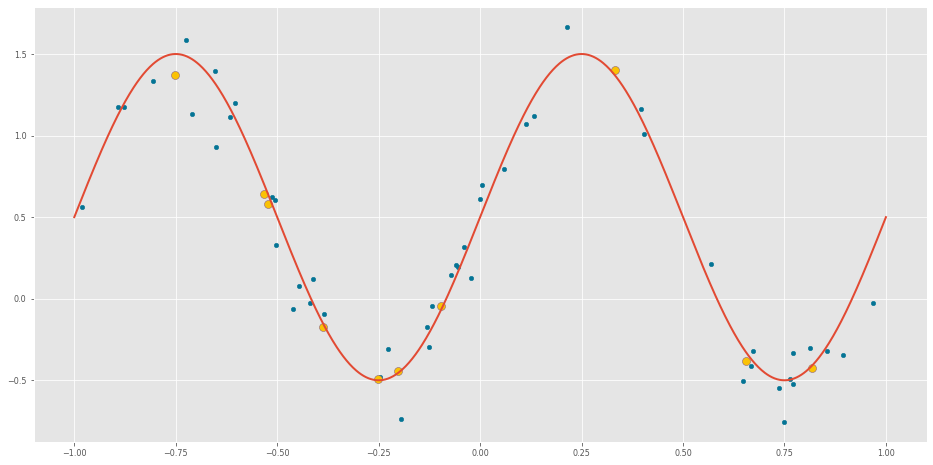

In [43]:
args = {}
plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, y2, linewidth=2)
plt.scatter(X_test, predict_equiv_kernel(X_test, X, t2, alpha, beta, args2), color=colors[7], edgecolor=colors[5], marker='o')
plt.show()

In the images below the value of the equivalent kernel is reported in color (reddish color - higher value) for all pairs in the domain $(-1,1)\times(-1,1)$ for different sets of base functions. It is possible to see that pairs with similar values (that is, points along the diagonal) tend to result into higher equivalent kernel values. As a consequence, when predicting $y(\mathbf{x})$ the target values of points in the training set at smaller distance from $\mathbf{x}$ receive higher weights: This corresponds to the application of a locality principle: nearby examples are more relevant for predictions.

In [44]:
n_values = 200
xx = np.linspace(-1, 1, n_values)
yy = np.linspace(-1, 1, n_values)
XX,YY = np.meshgrid(xx, yy)
func=np.vectorize(lambda x,y:equiv_kernel(x,y,X,t1,alpha,beta,args))
Z=func(XX,YY)

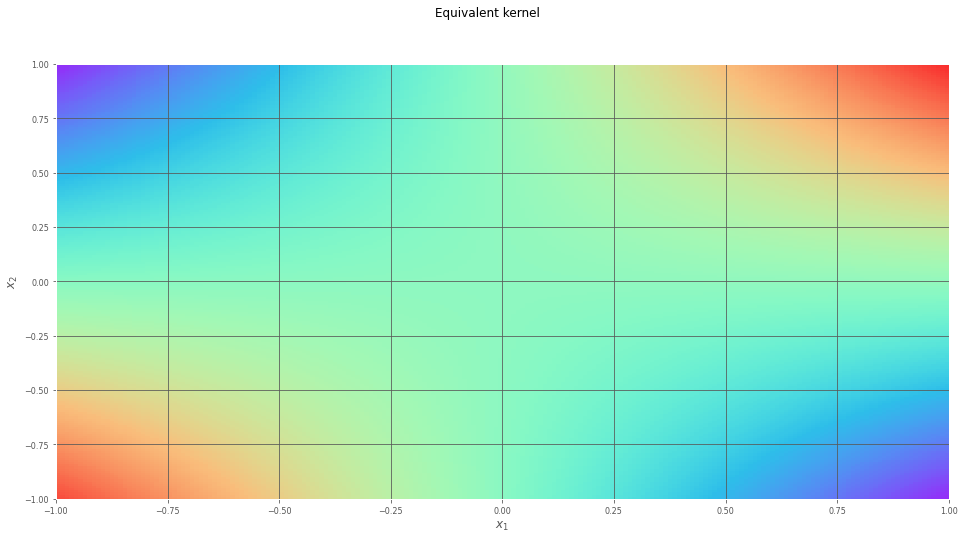

In [45]:
fig = plt.figure(figsize=(16,8))
ax=fig.gca()
imshow_handle = ax.imshow(Z, origin='lower', extent=(xx.min(),xx.max(), yy.min(), yy.max()), aspect='auto', alpha=.8, cmap='rainbow')
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(visible=True, which='both', color='0.35')
plt.suptitle(u'Equivalent kernel')
plt.show()

In [46]:
n_values = 200
xx = np.linspace(-1, 1, n_values)
yy = np.linspace(-1, 1, n_values)
XX,YY = np.meshgrid(xx, yy)
func = np.vectorize(lambda x,y:equiv_kernel(x,y,X,t2,alpha,beta,args2))
Z = func(XX,YY)

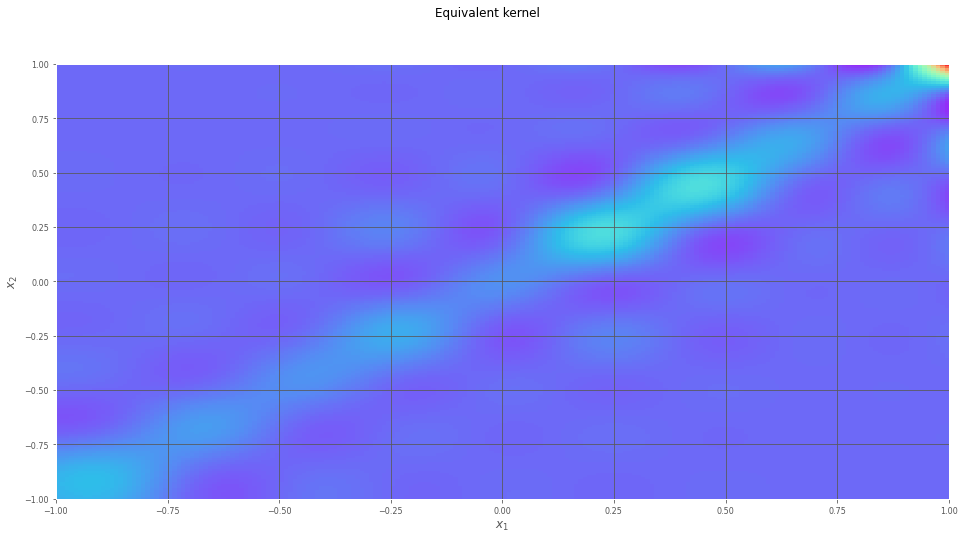

In [47]:
fig = plt.figure(figsize=(16,8))
ax=fig.gca()
imshow_handle = ax.imshow(Z, origin='lower', extent=(xx.min(),xx.max(), yy.min(), yy.max()), aspect='auto', alpha=.8, cmap='rainbow')
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(visible=True, which='both', color='0.35')
plt.suptitle(u'Equivalent kernel')
plt.show()

Equivalent kernel is a case of *nonparametric* model, a model where the prediction is not performed by applying a suitable parametric function on the feature domain. Instead, the prediction is now derived as a weighted linear combination of the target values in $\mathbf{t}$. 

The weight associated to $t_i$ is defined in terms of a *similarity measure* between the corresponding item $\mathbf{x}_i$ and the item $\mathbf{x}$ whose target must be predicted.

The similarity is defined in terms of a *kernel* function $\kappa(\mathbf{x}_i,\mathbf{x})$

### Kernel regression

In kernel regression methods, the  target value corresponding to any item $\mathbf{x}$ is  predicted by referring to items in the training set, and in particular to the items which are closer to $\mathbf{x}$. This is controlled by referring to a *kernel* function $\kappa_h(\mathbf{x})$, which is non zero only in an interval around $0$.

$h$ is the *bandwidth* of the kernel, which controls the width of $\kappa_h(\mathbf{x})$

A possible, common kernel, is the gaussian (or RBF) kernel 
$$
g(\mathbf{x})=e^{-\frac{{\left\lVert\mathbf{x}\right\rVert}^2}{2h^2}}
$$

 In regression, we are interested in estimating the conditional expectation
$$
f(\mathbf{x})= E[{t|\mathbf{x}}]=\int tp(t|\mathbf{x})dt=\int t\frac{p(\mathbf{x},t)}{p(\mathbf{x})}dt=\frac{\int t\;p(\mathbf{x},t)dt}{p(\mathbf{x})}=\frac{\int t\;p(\mathbf{x},t)dt}{\int p(\mathbf{x},t)dt}
$$

By approximating the joint distribution through the kernel
$$
 p(\mathbf{x},t)\approx\frac{1}{n}\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)\kappa_h(t-t_i)
$$
this results into
$$
 f(\mathbf{x})=\frac{\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)t_i}{\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)}
$$

By setting
$$
w_i(\mathbf{x})=\frac{\kappa_h(\mathbf{x}-\mathbf{x}_i)}{\sum_{j=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_j)}
$$
we can write
$$
f(\mathbf{x})=\sum_{i=1}^nw_i(\mathbf{x})t_i
$$
that is, the predicted value is computed as a normalized linear combination of all target values, weighted by kernels.

In [48]:
def kernel(x, X, sigma):
    dist_mat = cdist(X, x, 'minkowski', p=2.)
    return np.exp((-0.5 / (sigma ** 2)) * (dist_mat ** 2))

In [49]:
def predict_kernel(x, X, t, h, args):
    weights = kernel(expand(x, **args), expand(X, **args), h)
    y = (weights*t).sum(axis=0)/weights.sum(axis=0)
    if np.isscalar(x):
        return y.item()
    else:
        return y

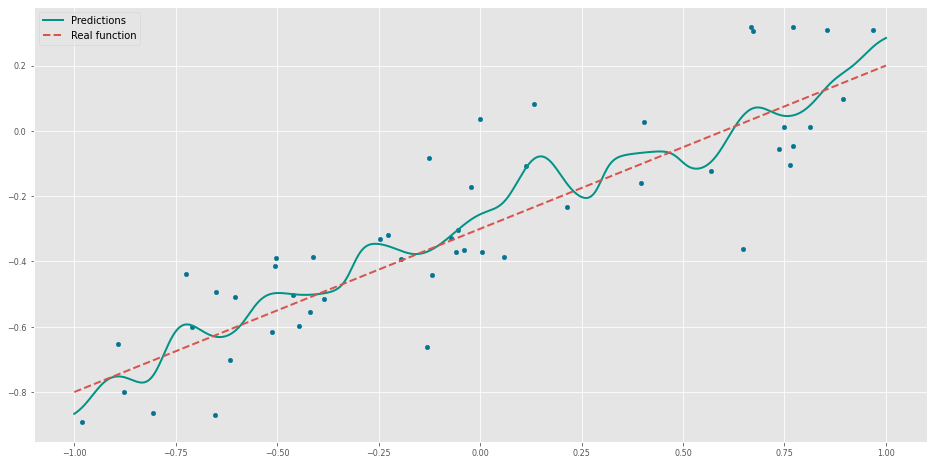

In [50]:
args = {}
h = .05
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict_kernel(x,X, t1, h, args), linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

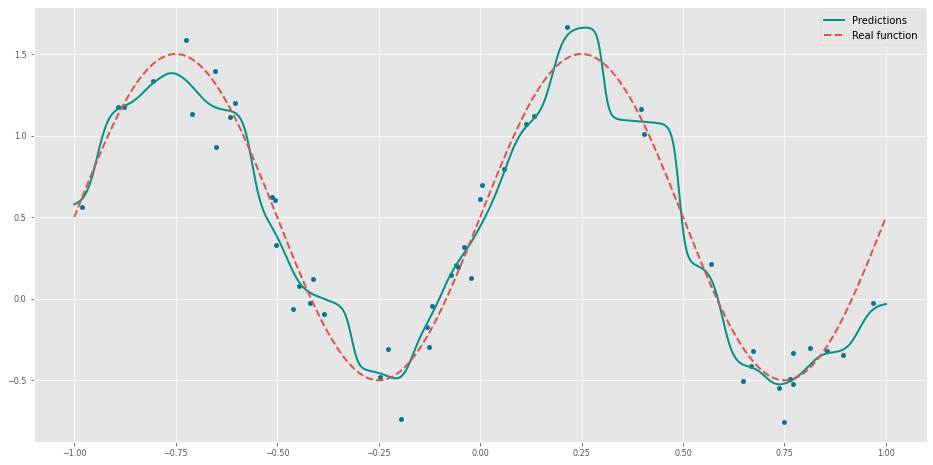

In [51]:
k = 10
mus = np.linspace(-1, 1, k)
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}
h = .1

fig = plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict_kernel(x, X, t2, h, args), linewidth=2, color=colors[6], label='Predictions')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

The best value for the bandwidth $h$ can be computed by selecting, in a given set of possible values, the one that result in the best predictions for a given set of items. Here, the items in the training set is considered.

In [52]:
def select_bandwidth(X, t, hs, args):
    mse = []
    for h in hs:
        XX = expand(X, **args)
        weights = kernel(XX, XX, h)
        weights = weights - np.diag(np.diag(weights))
        y = (weights*t).sum(axis=0)/weights.sum(axis=0)
        mse.append(((y[:, np.newaxis] - t) ** 2).mean())
    return hs[np.argmin(mse)]

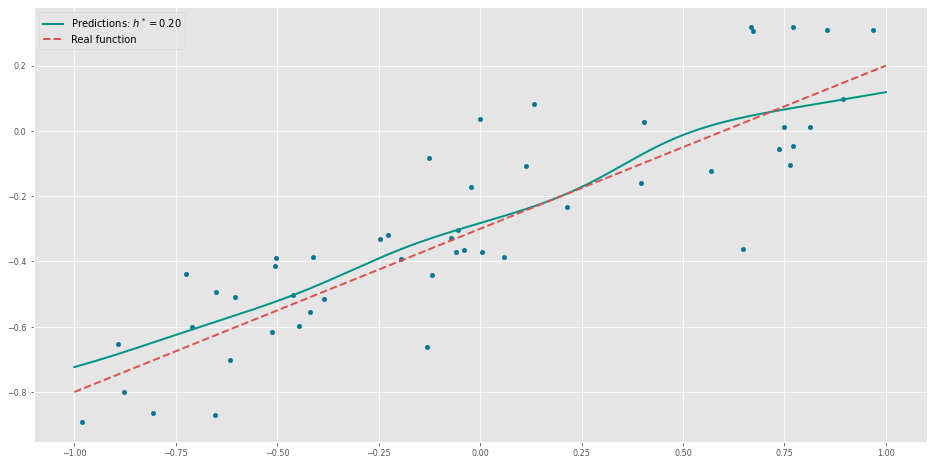

In [54]:
args = {}
hs=np.linspace(0.1, 1, 10)
h_star = select_bandwidth(X, t1, hs, args)
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(x, predict_kernel(x,X, t1, h_star, args), linewidth=2, color=colors[6], label=f'Predictions: $h^*={h_star:3.2f}$')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

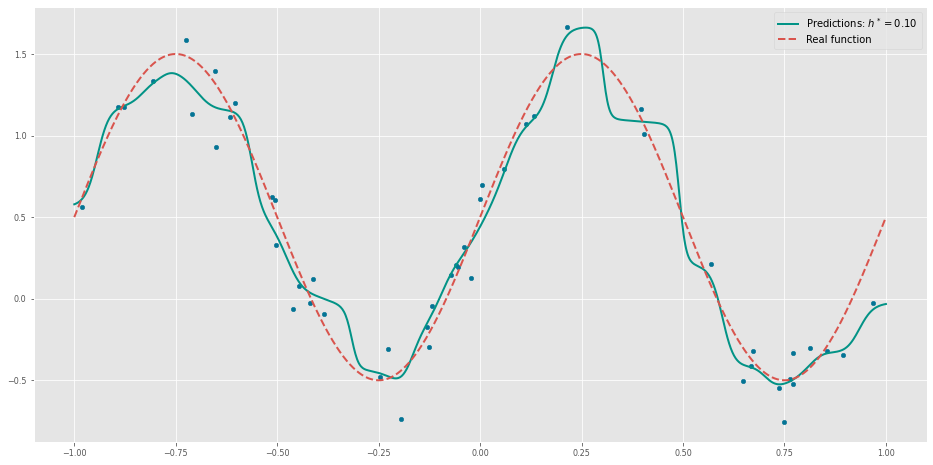

In [55]:
k = 10
mus = np.linspace(-1, 1, k)
args = {'bf': sigmoid_basis_function, 'bf_args_list':[{'mu':mu} for mu in mus]}

hs = np.linspace(0.1, 1, 10)
h_star = select_bandwidth(X, t2, hs, args)

fig = plt.figure(figsize=(16,8))
plt.scatter(X, t2, s=20, color=colors[1])
plt.plot(x, predict_kernel(x, X, t2, h_star, args), linewidth=2, color=colors[6], label=f'Predictions: $h^*={h_star:3.2f}$')
plt.plot(x, y2, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()

## Locally weighted regression

Locally weighted regression (LOESS) improves that approach by referring to a weighted version of the sum of squared differences loss function used in regression. 


If a value $t$ has to be predicted for an item $\mathbf{x}$, a _local_ version of the loss function is considered, 

$$
L(\mathbf{x})=\sum_{i=1}^n\kappa_i(\mathbf{x})(\mathbf{w}^T\overline{\mathbf{x}}_i-t_i)^2
$$

the weight $\kappa_i(\mathbf{x})$ is dependent from the _distance_ between $\mathbf{x}$ and $\mathbf{x}_i$, as defined by the kernel 
$$\kappa_i(\mathbf{x})=\kappa_h(\mathbf{x}-\mathbf{x}_i)$$

In [56]:
def kernel(x,xi,h):
    return np.exp(np.sum((xi - x) ** 2, axis=1) / (-2 * h * h))

The minimization of this loss function 
$$
\hat{\mathbf{w}}(\mathbf{x})=\argmin{\mathbf{w}}\sum_{i=1}^n\kappa_h(\mathbf{x}-\mathbf{x}_i)(\mathbf{w}^T\overline{\mathbf{x}}_i-t_i)^2
$$
has solution
$$
\hat{\mathbf{w}}(\mathbf{x}) = (\overline{\mathbf{X}}^T\Psi(\mathbf{x})\overline{\mathbf{X}})^{-1}\overline{\mathbf{X}}^T\Psi(\mathbf{x})\mathbf{t}
$$




In [57]:
def local_regression_coeffs(x, X, t, h):
    psi = diag_kernel(x, X, h)
    X_ext = np.c_[np.ones(len(X)), X]
    return np.linalg.pinv((X_ext.T @ psi) @ X_ext) @ X_ext.T @ psi @ t


where $\Psi(\mathbf{x})$ is a diagonal $n\times n$ matrix with $\Psi(\mathbf{x})_{ii}=\kappa_h(\mathbf{x}-\mathbf{x}_i)$


$$
\Psi(\mathbf{x}) = 
\begin{pmatrix}
\kappa_h(\mathbf{x}-\mathbf{x}_1) &  0 & \cdots & 0 \\ 
0 &  \kappa_h(\mathbf{x}-\mathbf{x}_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 &  0 & \cdots & \kappa_h(\mathbf{x}-\mathbf{x}_n)
\end{pmatrix}
$$



In [58]:
def diag_kernel(x, X, h):
    return np.diag(kernel(X,x,h))



The prediction is then performed as usual, as
$$
y = \hat{\mathbf{w}}(\mathbf{x})^T\overline{\mathbf{x}}
$$

In [59]:
def local_regression(x, X, t, h):
    x_ext = np.r_[1, x]
    w = local_regression_coeffs(x, X, t, h)
    return x_ext @ w

In [60]:
h = .05

In [61]:
x_ = 0.1

# calcola matrice kernel
psi = diag_kernel(np.array([x_]).reshape(-1,1),X,h)
domain = np.linspace(-1, 1, num=500)

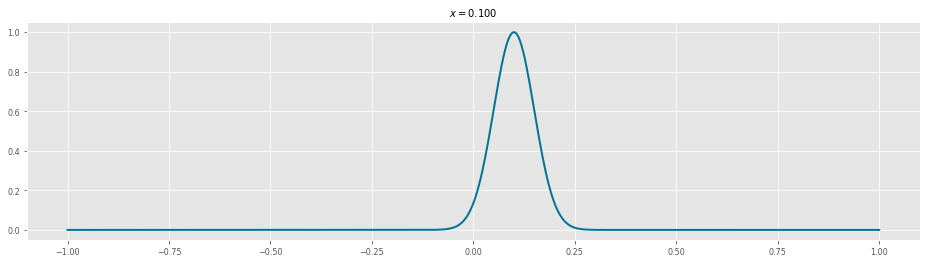

In [62]:
f = plt.figure(figsize=(16,4))
plt.title('$x={0:5.3f}$'.format(x_))
plt.plot(domain, kernel(x_,domain.reshape(-1,1),h), c=colors[1])
plt.show()

In [63]:
y = local_regression(x_, X, t1, h)
w = local_regression_coeffs(x_, X, t1, h)

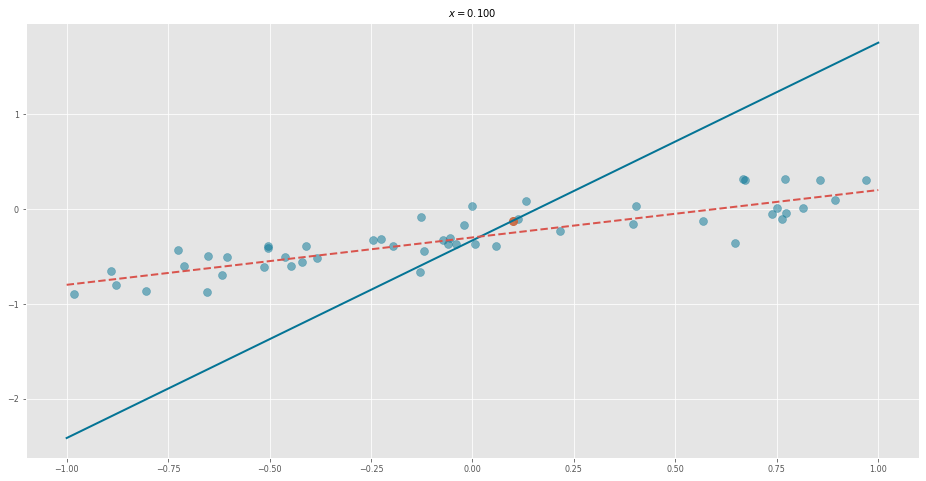

In [64]:
f = plt.figure(figsize=(16,8))
plt.title('$x={0:5.3f}$'.format(x_))
plt.scatter(X, t1, c= colors[1], alpha=.5)
plt.plot([x_], [y], marker='o', color=colors[4], alpha=.9)
plt.plot(domain, np.c_[np.ones(len(domain)), domain] @ w, color=colors[1])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.show()

In [65]:
prediction = [local_regression(x, X, t1, h) for x in domain]

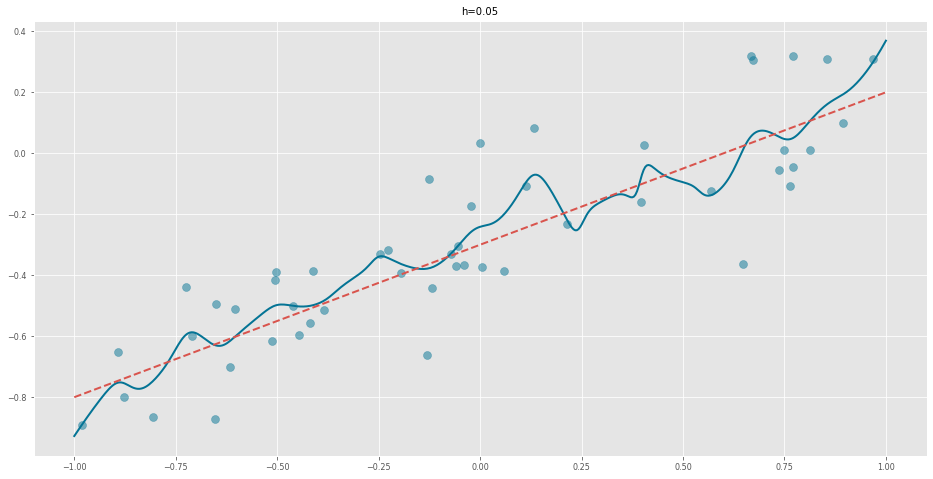

In [66]:
f = plt.figure(figsize=(16,8))
plt.title('h=%g' % h)
plt.scatter(X, t1, c= colors[1], alpha=.5)
plt.plot(domain, prediction, lw=2, c=colors[1])
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.show()

In [67]:
def select_bandwidth1(X, t, hs, args):
    XX = expand(X, **args)
    mse = []
    for h in hs:
        y = [local_regression(x, XX, t, h) for x in XX]
        mse.append(((y - t) ** 2).mean())
    return hs[np.argmin(mse)], np.min(mse)

In [68]:
hs = np.linspace(0.001, 0.002, 10)
h_star,mse=select_bandwidth1(X, t1, hs, args)

In [69]:
h_star,mse

(0.0013333333333333335, 2.6355835412557424e-20)

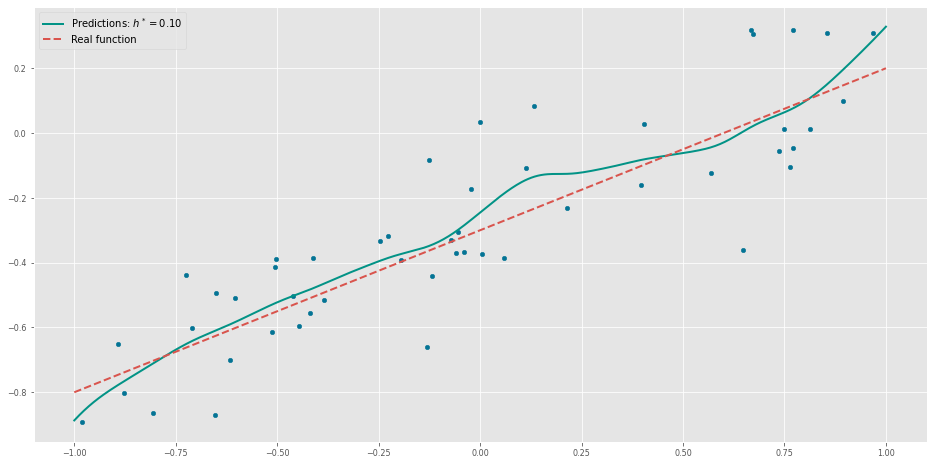

In [70]:
args = {}
hs=np.linspace(0.1, 1, 10)
h_star = select_bandwidth(X, t1, hs, args)
prediction_star = [local_regression(x, X, t1, h_star) for x in domain]
fig = plt.figure(figsize=(16,8))
plt.scatter(X, t1, s=20, color=colors[1])
plt.plot(domain, prediction_star, linewidth=2, color=colors[6], label=f'Predictions: $h^*={h_star:3.2f}$')
plt.plot(x, y1, linewidth=2, color=colors[2], linestyle='dashed', label='Real function')
plt.legend()
plt.show()